# Normative Modelling: Hierarchical Bayesian Regression with SHASH likelihood

Welcome to this tutorial notebook that will go through the fitting and evaluation of Normative models with a Hierarchical Bayesian Regression model using a SHASH likelihood. 

Let's jump right in.

### Imports

In [1]:
import warnings
import logging
import os
import sys


import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit import (
    HBR,
    BsplineBasisFunction,
    NormativeModel,
    NormData,
    #load_fcon1000,
    SHASHbLikelihood,
    make_prior,
    plot_centiles,
    plot_qq,
    plot_ridge,
    Runner
)

import numpy as np
import pcntoolkit.util.output
import seaborn as sns

sns.set_style("darkgrid")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)

## Load data

First we convert the data into a NormData Object

In [2]:
#data_in_dir = '/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/DATA_new_version/SC'
data_in_dir = '/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/DATA/SC'

train = pd.read_pickle(os.path.join(data_in_dir,"train_SC_demented_adults_ADNI.pkl"))
test = pd.read_pickle(os.path.join(data_in_dir,"test_SC_demented_adults_ADNI.pkl"))

#train = pd.read_pickle(os.path.join(data_in_dir,"train_retrain_full_models_SC_adults_ADNI.pkl"))
#test = pd.read_pickle(os.path.join(data_in_dir,"train_retrain_full_models_SC_adults_ADNI.pkl"))


features_to_model = list(train.columns)
features_to_model

['Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 '3rd-Ventricle',
 '4th-Ventricle',
 'Brain-Stem',
 'Left-Hippocampus',
 'Left-Amygdala',
 'CSF',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Right-Lateral-Ventricle',
 'Right-Inf-Lat-Vent',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus',
 '5th-Ventricle',
 'WM-hypointensities',
 'non-WM-hypointensities',
 'Optic-Chiasm',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'BrainSegVol',
 'lhCortexVol',
 'rhCortexVol',
 'SubCortGrayVol',
 'TotalGrayVol',
 'SupraTentorialVol',
 'SupraTentorialVolNotVent',
 'BrainSegVol-to

In [3]:
#plotdir = os.path.join(out_dir, "plots")# Select only a few features
covariates = ["age"]
batch_effects = ["sex", "site_id2"]

# features_to_model = [
#     'L_bankssts',
#  'L_caudalanteriorcingulate',
#  'L_caudalmiddlefrontal',
#  'L_cuneus',
#  'L_entorhinal',
#  'L_fusiform',
#  'L_inferiorparietal',
#  'L_inferiortemporal',
#  'L_isthmuscingulate',
#  'L_lateraloccipital',
#  'L_lateralorbitofrontal',
#  'L_lingual',
#  'L_medialorbitofrontal',
#  'L_middletemporal',
#  'L_parahippocampal',
#  'L_paracentral',
#  'L_parsopercularis',
#  'L_parsorbitalis',
#  'L_parstriangularis',
#  'L_pericalcarine',
#  'L_postcentral',
#  'L_posteriorcingulate',
#  'L_precentral',
#  'L_precuneus',
#  'L_rostralanteriorcingulate',
#  'L_rostralmiddlefrontal',
#  'L_superiorfrontal',
#  'L_superiorparietal',
#  'L_superiortemporal',
#  'L_supramarginal',
#  'L_frontalpole',
#  'L_temporalpole',
#  'L_transversetemporal',
#  'L_insula',
#  'R_bankssts',
#  'R_caudalanteriorcingulate',
#  'R_caudalmiddlefrontal',
#  'R_cuneus',
#  'R_entorhinal',
#  'R_fusiform',
#  'R_inferiorparietal',
#  'R_inferiortemporal',
#  'R_isthmuscingulate',
#  'R_lateraloccipital',
#  'R_lateralorbitofrontal',
#  'R_lingual',
#  'R_medialorbitofrontal',
#  'R_middletemporal',
#  'R_parahippocampal',
#  'R_paracentral',
#  'R_parsopercularis',
#  'R_parsorbitalis',
#  'R_parstriangularis',
#  'R_pericalcarine',
#  'R_postcentral',
#  'R_posteriorcingulate',
#  'R_precentral',
#  'R_precuneus',
#  'R_rostralanteriorcingulate',
#  'R_rostralmiddlefrontal',
#  'R_superiorfrontal',
#  'R_superiorparietal',
#  'R_superiortemporal',
#  'R_supramarginal',
#  'R_frontalpole',
#  'R_temporalpole',
#  'R_transversetemporal',
#  'R_insula',
#  'Mean_Thickness',
#  'Median_Thickness'
# ]



features_to_model = [
    'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
    'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 '3rd-Ventricle',
 '4th-Ventricle',
 'Brain-Stem',
 'Left-Hippocampus',
 'Left-Amygdala',
 'CSF',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Right-Lateral-Ventricle',
 'Right-Inf-Lat-Vent',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
    'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus',
 '5th-Ventricle',
 'WM-hypointensities',
 'non-WM-hypointensities',
 'Optic-Chiasm',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'BrainSegVol',
 'lhCortexVol',
 'rhCortexVol',
 'SubCortGrayVol',
 'TotalGrayVol',
 'SupraTentorialVol',
 'SupraTentorialVolNotVent',
 'BrainSegVol-to-eTIV',
 'MaskVol-to-eTIV',
 'lhSurfaceHoles',
 'rhSurfaceHoles',
 'EstimatedTotalIntraCranialVol'
] 

#features_to_model = [
    #"Left-Thalamus",
    #"Right-Thalamus"
    #"Right-Amygdala",
    #"Right-Hippocampus"
#]



norm_train = NormData.from_dataframe(
    name="train", dataframe=train, covariates=covariates, batch_effects=batch_effects, response_vars=features_to_model
)
norm_test = NormData.from_dataframe(
    name="test", dataframe=test, covariates=covariates, batch_effects=batch_effects, response_vars=features_to_model
)



In [4]:
train.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rhSurfaceHoles,EstimatedTotalIntraCranialVol,ID_subject,age,sex,site_id,ID_visit,which_dataset,set,site_id2
0,10225.7,199.5,16272.5,50760.5,7970.6,3467.0,4778.8,1920.7,855.1,1790.0,...,13.0,1.578481e+06,339A,36.0,1.0,501,1,1,1,1
1,4696.8,296.4,14975.9,54470.6,6881.2,4122.0,5681.0,2041.6,770.0,1893.1,...,14.0,1.551816e+06,346A,20.0,1.0,501,1,1,1,1
2,3651.6,285.2,17288.5,58953.2,8867.1,3445.9,4943.0,2305.1,773.4,1827.8,...,8.0,1.636059e+06,349A,23.0,0.0,501,1,1,1,1
3,8884.9,286.2,16655.9,60907.2,8383.2,4338.3,5399.7,2075.0,1179.8,2382.7,...,24.0,1.789552e+06,350A,25.0,0.0,501,1,1,1,1
4,7111.2,174.0,14155.5,51977.6,7228.0,4490.8,5631.3,2261.2,1106.9,2080.0,...,20.0,1.493346e+06,351A,30.0,0.0,501,1,1,1,1


In [5]:
norm_train.head()

<xarray.NormData> Size: 2kB
Dimensions:            (observations: 5, response_vars: 5, covariates: 1,
                        batch_effect_dims: 2)
Coordinates:
  * observations       (observations) int64 40B 0 1 2 3 4
  * response_vars      (response_vars) <U29 580B 'Left-Lateral-Ventricle' ......
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U8 64B 'sex' 'site_id2'
Data variables:
    subject_ids        (observations) int64 40B 0 1 2 3 4
    Y                  (observations, response_vars) float64 200B 1.023e+04 ....
    X                  (observations, covariates) float64 40B 36.0 20.0 ... 30.0
    batch_effects      (observations, batch_effect_dims) <U32 1kB '1.0' ... '...
Attributes:
    real_ids:                       False
    is_scaled:                      False
    name:                           train
    unique_batch_effects:           {np.str_('sex'): [np.str_('0.0'), np.str_...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('age'): {'mean': np.float64(50.2...
    batch_effect_covariate_ranges:  {np.str_('sex'): {np.str_('0.0'): {np.str...

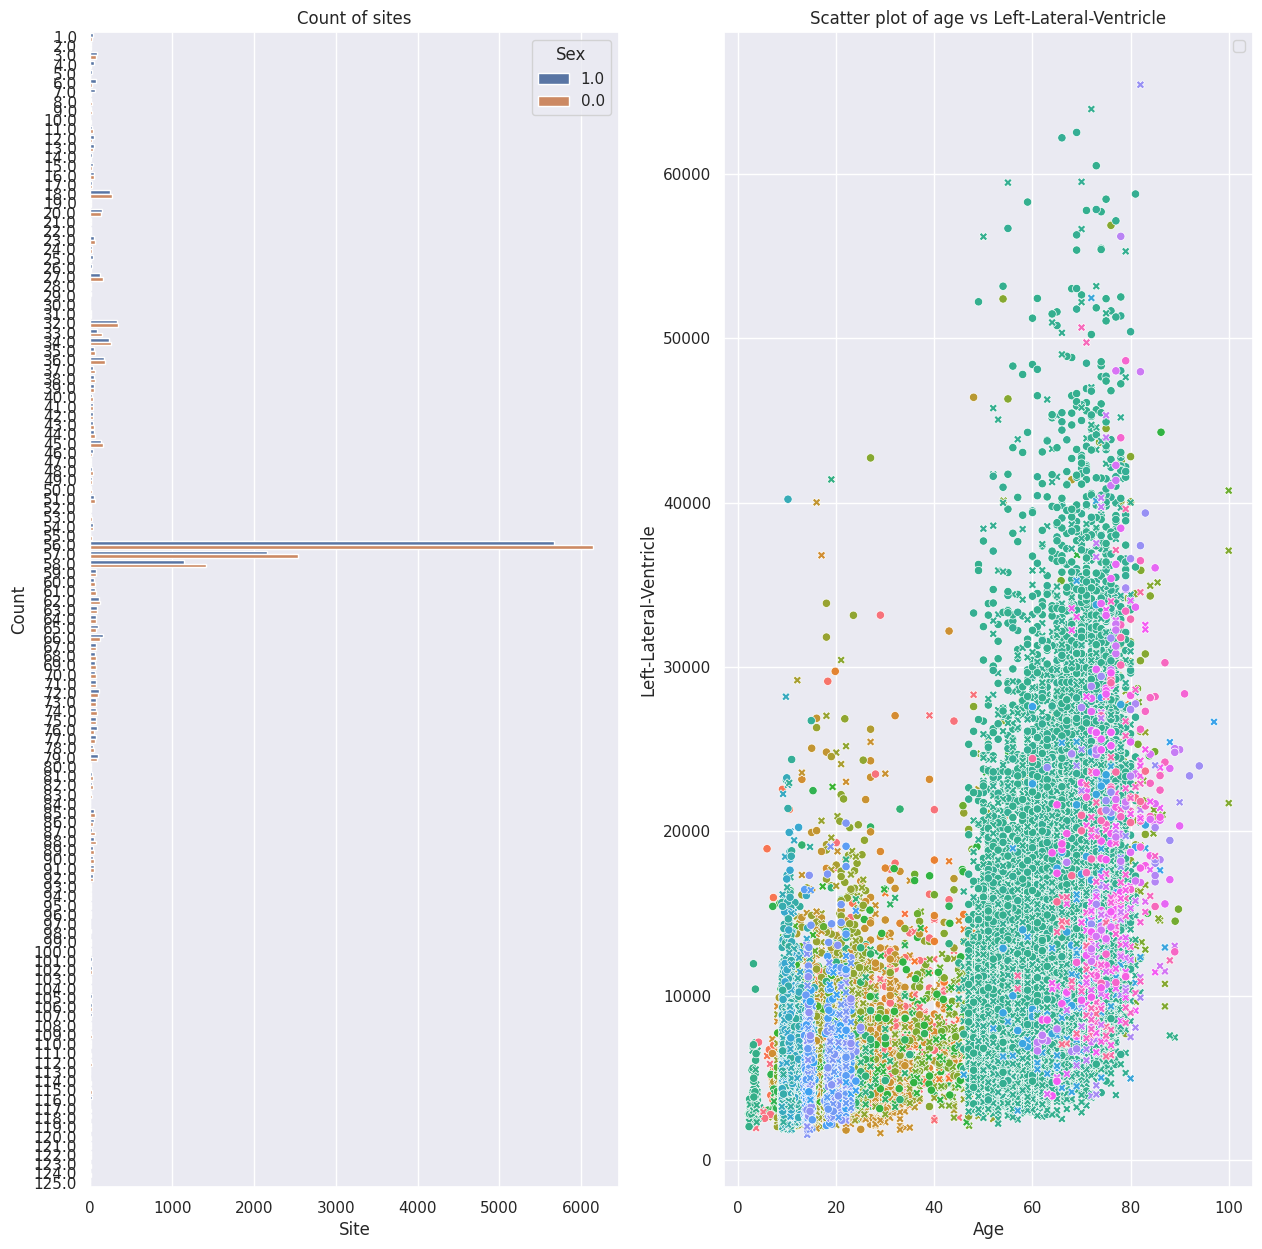

In [6]:
# Visualize the data
feature_to_plot = features_to_model[0]
df = norm_train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

sns.countplot(data=df, y=("batch_effects", "site_id2"), hue=("batch_effects","sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")


sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", feature_to_plot),
    hue=("batch_effects", "site_id2"),
    style=("batch_effects","sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {feature_to_plot}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)

plt.show()

In [7]:
print(norm_train.check_compatibility(norm_test))

True


## Creating a Normative model

A normative model has a regression model for each response variable. We provide a template regression model which is copied for each response variable. 

A template regression model can be anything that extends the `RegressionModel`. We provide a number of built-in regression models, but you can also create your own. 

Here we use the `HBR` class, which implements a Hierarchical Bayesian Regression model. 


### Likelihoods

`HBR` models are composed of a likelihood and a number of priors on the parameters of the likelihood. The PCNtoolkit offers a number of likelihood functions:
1. NormallLikelihood: Good for modeling data that is (approximately) normally distributed.
2. SHASHbLikelihood: Good for modeling data that is heavily skewed, or tailed. 
3. BetaLikelihood: Good for modeling data that is bounded, e.g. between 0 and 1.

### Likelihood parameters

Each of these likelihoods takes their own set of parameters, and for each, we have to set a prior:
1. NormalLikelihood:
    - `mu`: The mean of the normal distribution.
    - `sigma`: The standard deviation of the normal distribution.
2. SHASHbLikelihood:
    - `mu`: The mean of the skew-normal distribution.
    - `sigma`: The standard deviation of the skew-normal distribution.
    - `epsilon`: The skewness parameter of the skew-normal distribution.
    - `delta`: The tail thickness (or kurtosis) of the skew-normal distribution.
3. BetaLikelihood:
    - `alpha`: The shape parameter of the beta distribution.
    - `beta`: The scale parameter of the beta distribution.

### Configuring likelihood parameters

Each likelihood parameter needs to be configured. The defaults should work reasonably well for most cases, at least where the data is standardized. Here's a quick guide to configuring the likelihood parameters yourself, using the `make_prior` function.

1. Is your parameter a function of the covariates? If so, you set the `linear` parameter to `True`.
   1. If so, you can choose the basis expansion to use for the parameter: BSplineBasisFunction, LinearBasisFunction, or PolynomialBasisFunction.
   2. Also, determine whether the slope and intercept of the prior have a random effect or not. Here's an example of a linear prior with a bspline basis expansion and a random effect in the intercept. 

```python
mu = make_prior('mu', linear=True, basis_function=BSplineBasisFunction(degree=3, nknots=5), intercept = make_prior('intercept_mu', random=True))
```

2. If your parameter is not a function of the covariates, you have to decide whether the parameter itself has a random effect or not. Here's an example of a prior with a random effect.

```python
epsilon = make_prior('epsilon', random=True)
```

3. Some parameters (such as sigma) need to be strictly positive, which we can enforce with a mapping. Here's an example of a prior with a mapping to the positive real line.

```python
# The mapping_params are (horizontal shift, scaling, vertical shift)
sigma = make_prior('sigma', mapping='softplus', mapping_params=(0, 5, 0))
```


4. Any non-linear parameters can be further configured with `dist_name` and `dist_params`. Here's an example of a prior with a gamma distribution. 

```python
alpha = make_prior('alpha', dist_name='gamma', dist_params=(1, 1))
```
We currently support the following distributions:
- Normal
- HalfNormal
- LogNormal
- Uniform
- Gamma
  
The order of the parameters is important, and follows the order of the parameters in the corresponding distributions in PyMC.


### Creating a HBR model

Here's a thoroughly commented example of a HBR model with a SHASH Likelihood, which we will use to model our response variable.

In [7]:
# The SHASHb likelihood is a bit more flexible than the Normal likelihood, and takes four parameters, mu, sigma, epsilon, and delta.
# Mu and sigma fulfill the same role as in the Normal likelihood, namely the mean and standard deviation of the distribution.
# Epsilon and delta are parameters that control the skewness and kurtosis of the distribution.

# SHASHb model with fixed values for epsilon and delta

mu = make_prior(
    # Mu is linear because we want to allow the mean to vary as a function of the covariates.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 10.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    # The intercept is random, because we expect the intercept to vary between sites and sexes.
    intercept=make_prior(
        random=True,
        # Mu is the mean of the intercept, which is normally distributed with a mean of 0 and a standard deviation of 1.
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
        # Sigma is the scale at which the intercepts vary. It is a positive parameter, so we have to map it to the positive domain.
        sigma=make_prior(dist_name="Normal", dist_params=(0.0, 1.0), mapping="softplus", mapping_params=(0.0, 3.0)),
    ),
    # We use a B-spline basis function to allow for non-linearity in the mean.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    # Sigma is also linear, because we want to allow the standard deviation to vary as a function of the covariates: heteroskedasticity.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 2.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 2.0)),
    # The intercept is not random, because we assume the intercept of the variance to be the same for all sites and sexes.
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    # We use a B-spline basis function to allow for non-linearity in the standard deviation.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    # We use a softplus mapping to ensure that sigma is strictly positive.
    mapping="softplus",
    # We scale the softplus mapping by a factor of 3, to avoid spikes in the resulting density.
    # The parameters (a, b, c) provided to a mapping f are used as: f_abc(x) = f((x - a) / b) * b + c
    # This basically provides an affine transformation of the softplus function.
    # a -> horizontal shift
    # b -> scaling
    # c -> vertical shift
    # You can leave c out, and it will default to 0.
    mapping_params=(0.0, 3.0),
)

epsilon = make_prior(
    # Epsilon is assumed to follow a normal distribution, with a mean of 0 and a standard deviation of 1.
    dist_name="Normal",
    dist_params=(0.0, 1.0),
)

delta = make_prior(
    # Delta is sampled from a normal distribution, with a mean of 1 and a standard deviation of 1, and then mapped to the positive real line using a softplus function.
    dist_name="Normal",
    dist_params=(1.0, 1.0),
    mapping="softplus",
    # We apply a softplus mapping to the delta parameter, to ensure that it is strictly positive.
    mapping_params=(
        0.0,  # Horizontal shift
        3.0,  # Scale for smoothness
        0.6,  # We need to provide a vertical shift as well, because the SHASH mapping goes a bit wild with low values for delta
    ),
)

shashb1_regression_model = HBR(
    name="template",
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
    nuts_sampler="nutpie",
    likelihood=SHASHbLikelihood(mu, sigma, epsilon, delta),
)

After specifying the regression model, we can configure a normative model. 

A normative model has a number of configuration options:
- `savemodel`: Whether to save the model after fitting.
- `evaluate_model`: Whether to evaluate the model after fitting.
- `saveresults`: Whether to save the results after evaluation.
- `saveplots`: Whether to save the plots after fitting.
- `save_dir`: The directory to save the model, results, and plots.
- `inscaler`: The scaler to use for the input data.
- `outscaler`: The scaler to use for the output data.




In [9]:
model = NormativeModel(
    # The regression model to use for the normative model.
    template_regression_model=shashb1_regression_model,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=True,
    # The directory to save the model, results, and plots.
    save_dir="/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/CODE_new/models_public/save_dir_SC_SHASH_all_regions", # redo with old data set
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robminmax", "none"
    outscaler="standardize",
)

In [10]:
sns.set_theme(style="darkgrid")

# Get the conda environment path
conda_env_path = os.path.join(os.path.dirname(os.path.dirname(sys.executable)))
print(f"This should be the conda environment path: {conda_env_path}")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")
pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(True)

This should be the conda environment path: /home/preclineu/johbay/.conda/envs/pcntoolkit_p312


## Fit the model


With all that configured, we can fit the model. 

The `fit_predict` function will fit the model, evaluate it, and save the results and plots (if so configured). 

After that, it will compute Z-scores and centiles for the test set. 

All results can be found in the save directory. 

In [11]:
runner = Runner(
    cross_validate=False,
    parallelize=True,
    environment=conda_env_path,
    job_type="slurm",  # or "torque" if you are on a torque cluster
    n_batches=51,
    time_limit="72:00:00",
    n_cores = 8,
    memory = '40gb',
    log_dir="/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/CODE_new/models_public/runner_output/log_dir",
    temp_dir="/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/CODE_new/models_public/runner_output/temp_dir",
)

In [12]:
runner.fit_predict(model,norm_train, norm_test)
#plot_centiles(model, scatter_data=train)


---------------------------------------------------------
              PCNtoolkit Job Status Monitor ®
---------------------------------------------------------
Task ID: fit_predict_train__2025-12-30_14:18:50_674.804199
---------------------------------------------------------
Job ID      Name          State      Time      Nodes
---------------------------------------------------------

50095829    fit_predict_train__2025-12-30_14:18:50_674.804199_job_0 COMPLETED                          
50095830    fit_predict_train__2025-12-30_14:18:50_674.804199_job_1 COMPLETED                          
50095831    fit_predict_train__2025-12-30_14:18:50_674.804199_job_2 COMPLETED                          
50095832    fit_predict_train__2025-12-30_14:18:50_674.804199_job_3 COMPLETED                          
50095833    fit_predict_train__2025-12-30_14:18:50_674.804199_job_4 COMPLETED                          
50095834    fit_predict_train__2025-12-30_14:18:50_674.804199_job_5 COMPLETED           

In [7]:
import copy
w_dir = "/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/CODE_new/PCNtoolkit/examples/resources/hbr_SHASH/save_dir_new/"
region = "Left-Lateral-Ventricle"
model= NormativeModel.load(os.path.join(w_dir)) # i'm using batches of variabels but your just grab the NormativeModel.json object here wherever it is for oyu
response_var = f'{region}'



#select a single var to avoid plotting the whole batch
def select_for_response_var(model: NormativeModel, data: NormData, response_var: str):
    if response_var not in model.regression_models:
        raise ValueError(f"Response variable '{response_var}' not in model.")
    new_model = copy.deepcopy(model)
    new_model.response_vars = [response_var]
    new_model.regression_models = {response_var: new_model.regression_models[response_var]}
    new_model.outscalers = {response_var: new_model.outscalers[response_var]} if new_model.outscalers else {}
    ## there might be some extra attributes to grab here if you're using HBR though, i haven't used it
    new_data = data.sel({"response_vars": response_var}, drop=False)
    new_data["Y"] = new_data.Y.expand_dims("response_vars", axis=-1) #preserves 1d of norm_data.Y because single voxel, otherwise plot will error
    new_data = new_data.assign_coords(response_vars=[response_var])
    return new_model, new_data
    
modelvox, testvox = select_for_response_var(model, norm_test, region) 


## Plot the results

The PCNtoolkit offers are a number of different plotting functions:
1. plot_centiles: Plot the predicted centiles for a model
2. plot_qq: Plot the QQ-plot of the predicted Z-scores
3. plot_ridge: Plot density plots of the predicted Z-scores

Let's start with the centiles.

In [44]:
model.response_vars[0]

'Brain-Stem'

In [10]:
runner.save_dir = model.save_dir

In [11]:
model =runner.load_model()

In [ ]:
plot_centiles(
    modelvox,
    #centiles=[0.05, 0.5,0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=testvox,
    batch_effect='all',
    # Scatter this data along with the centiles
    #batch_effects={"site_id2": ["1.0"], "sex": ["0.0"]},  # Highlight these groups
    show_other_data=True,
    style='site', # scatter data not in those groups as smaller black circles
    harmonize=True,  # harmonize the scatterdata, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
)

Now let's see the qq plots

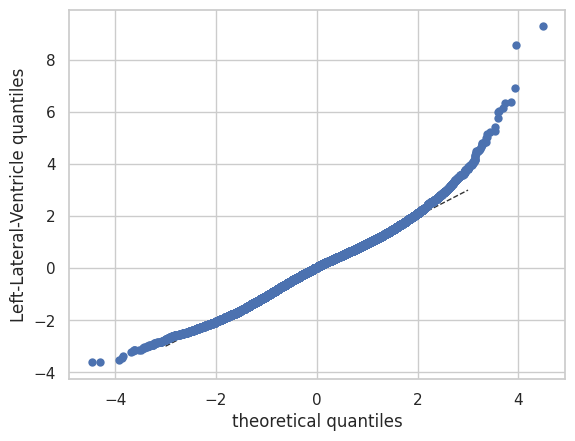

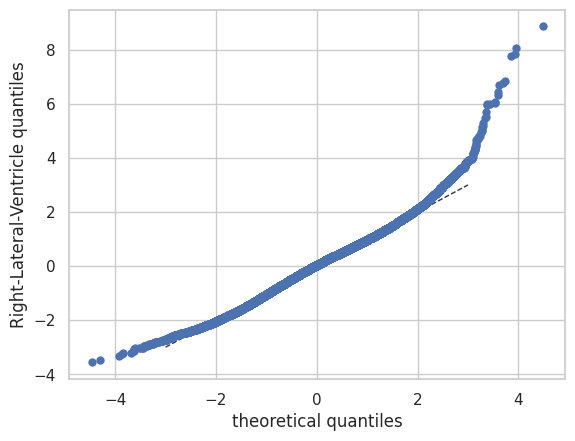

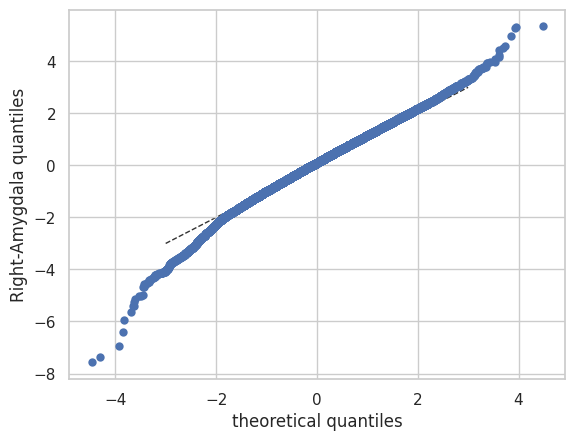

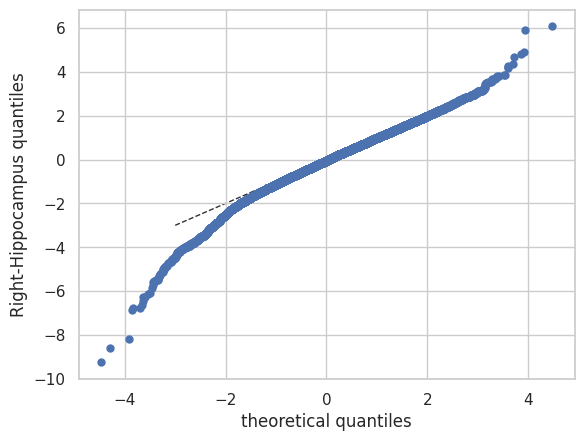

In [25]:
plot_qq(norm_test, plot_id_line=True)

In [48]:
norm_train.load_results("/project_cephfs/3022017.06/projects/lifespan_hbr/johbay/Velocity/CODE_new/PCNtoolkit/examples/resources/hbr_SHASH/save_dir_new/results/")

We can also split the QQ plots by batch effects:

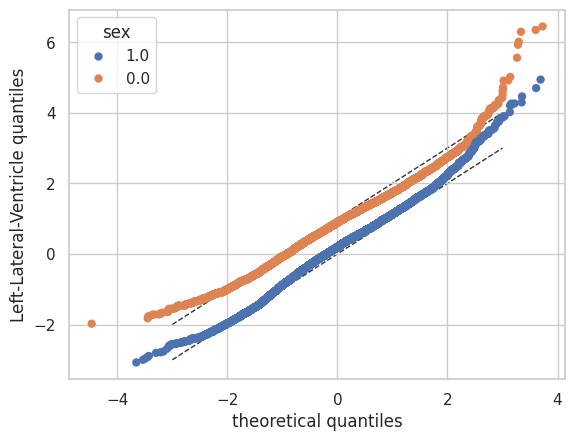

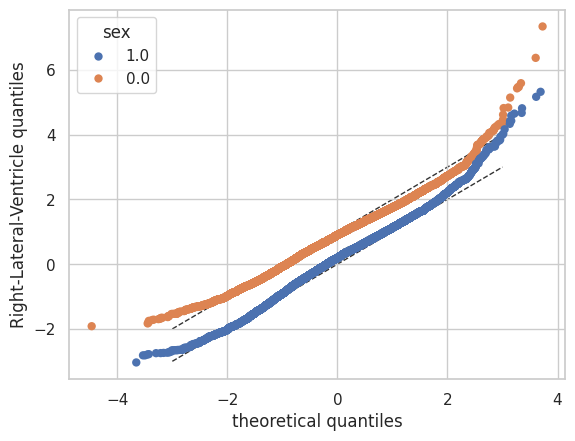

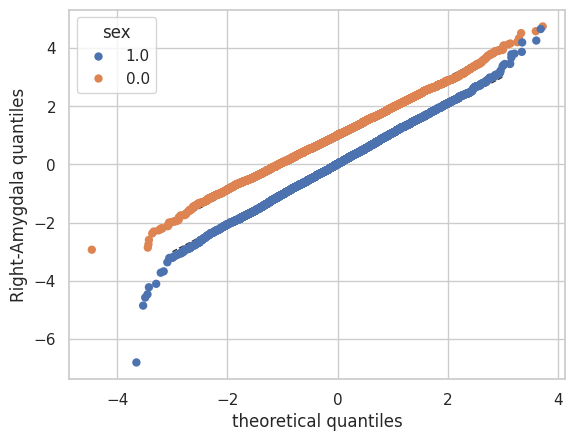

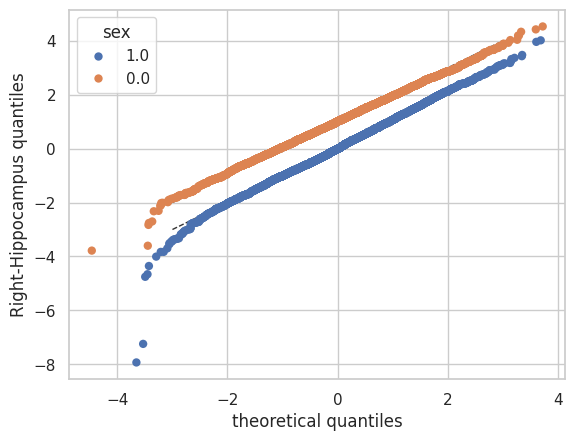

In [26]:
plot_qq(norm_train, plot_id_line=True, hue_data="sex", split_data="sex")
sns.set_theme(style="darkgrid", rc={"axes.facecolor": (0, 0, 0, 0)})

And finally the ridge plot:

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

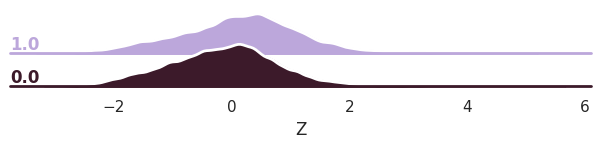

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

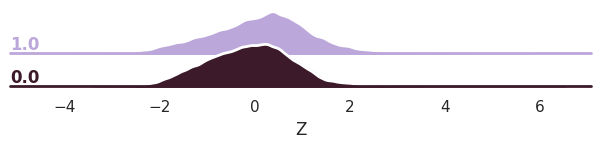

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

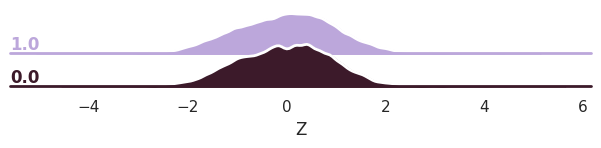

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

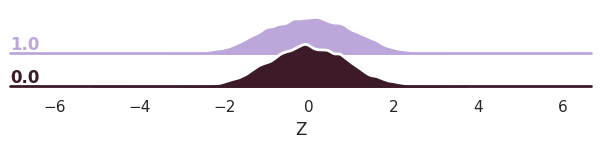

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

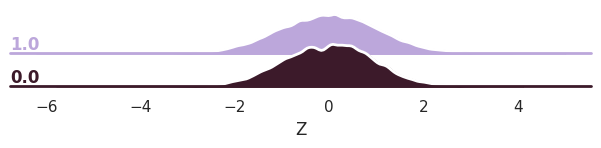

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

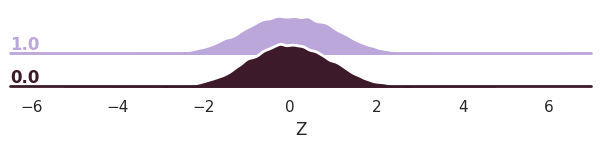

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

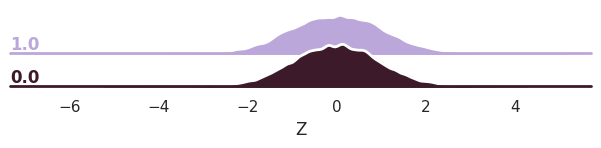

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

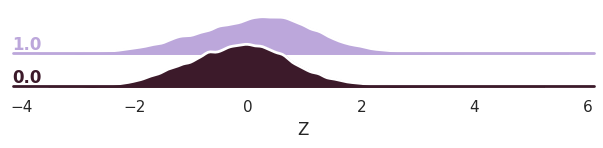

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

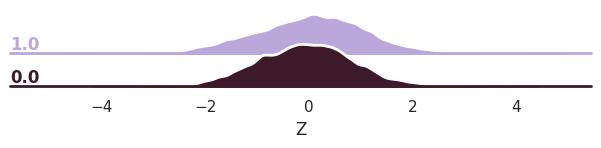

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

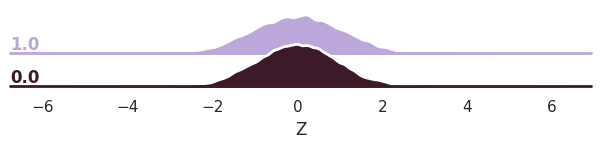

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

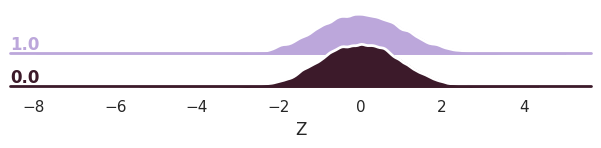

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

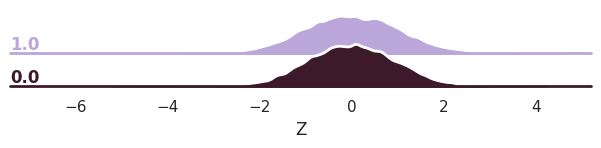

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

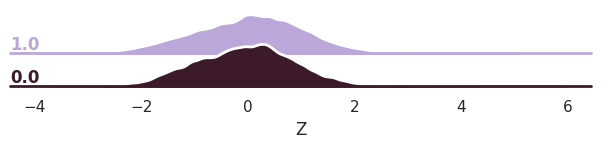

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

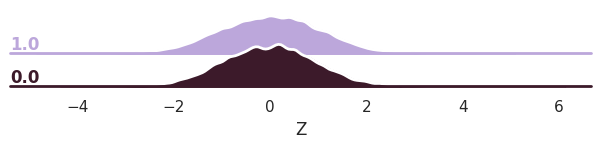

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

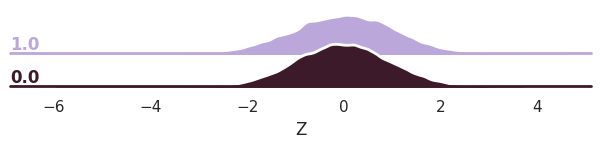

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

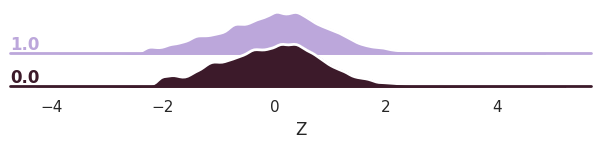

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

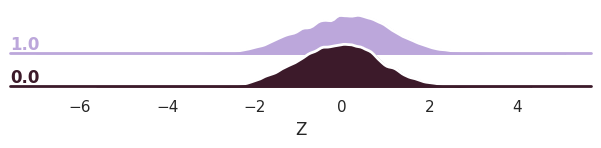

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

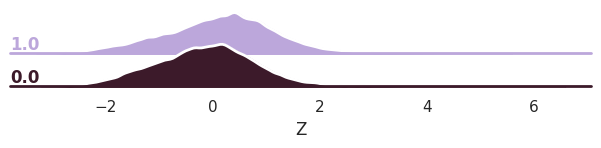

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

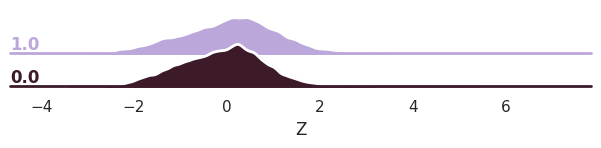

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

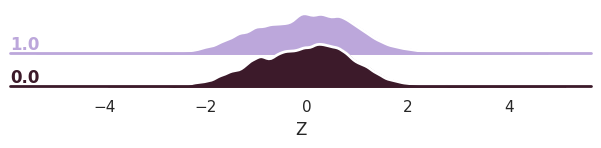

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

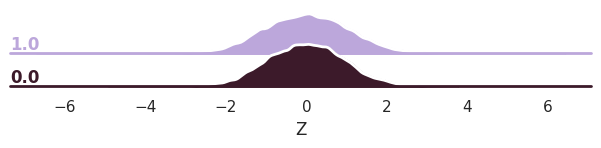

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

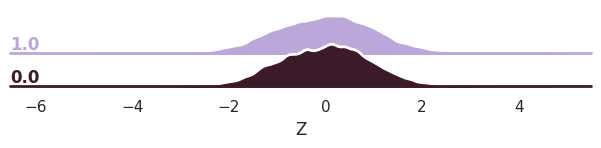

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

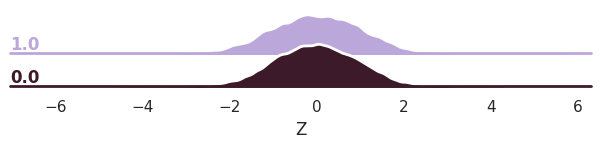

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

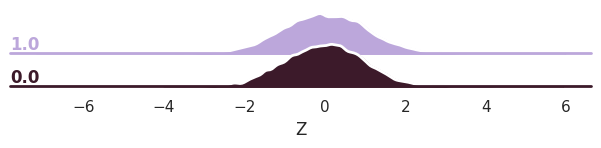

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

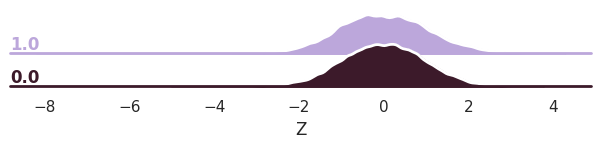

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

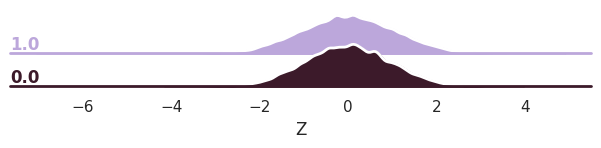

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

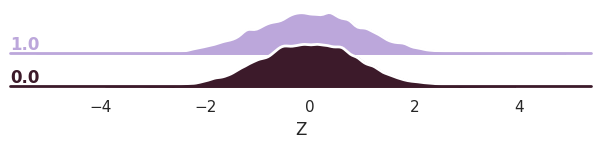

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

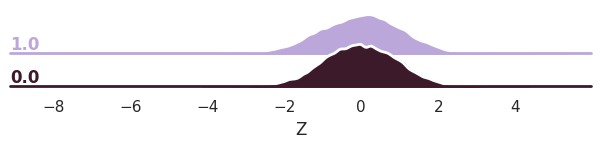

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

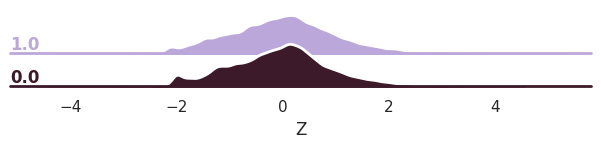

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

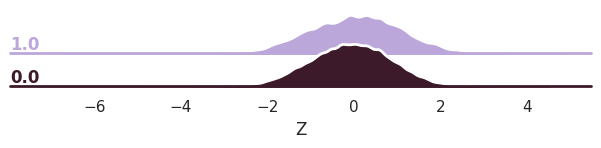

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

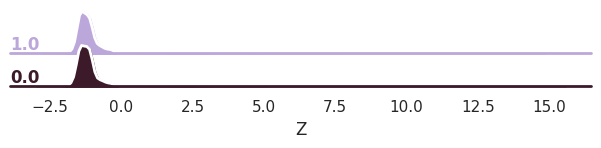

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

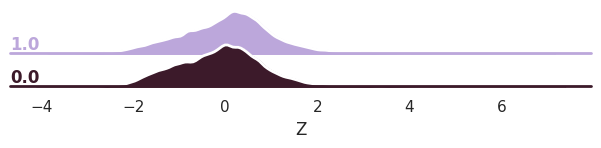

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

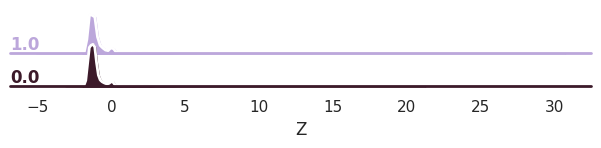

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

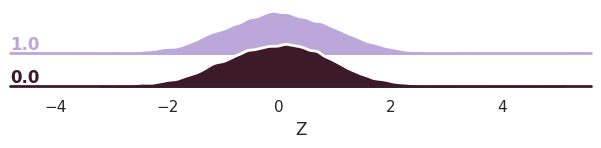

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

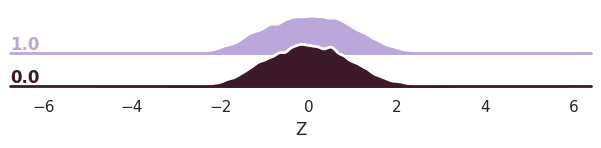

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

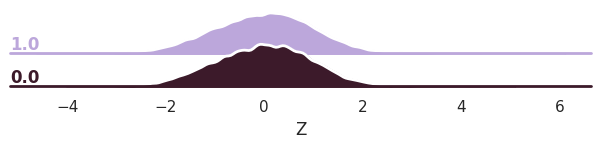

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

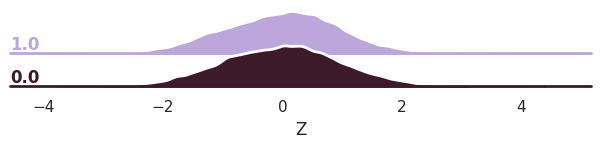

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

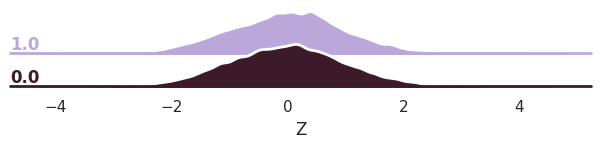

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

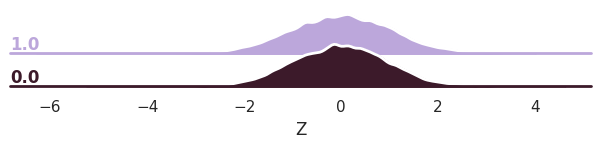

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

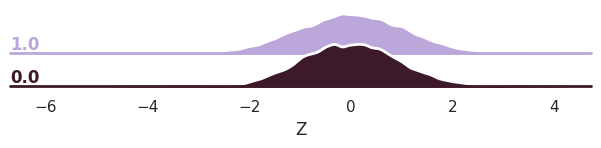

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

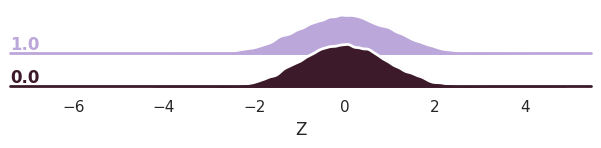

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

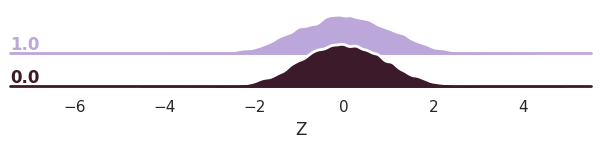

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

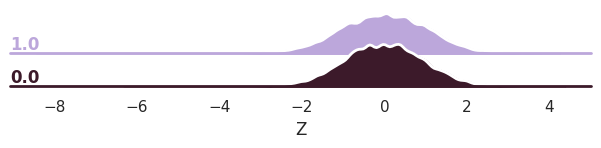

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

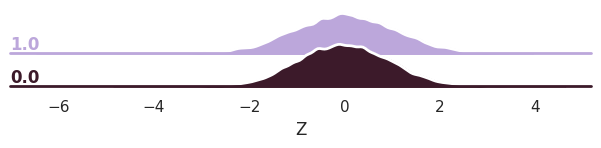

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

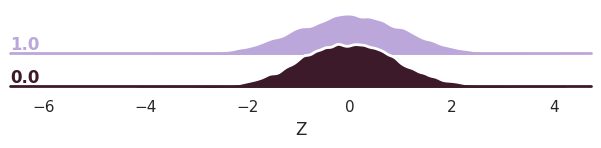

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

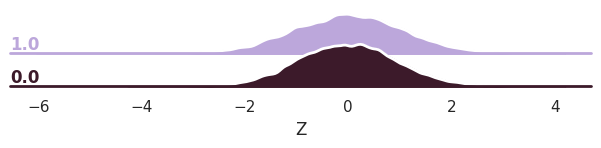

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

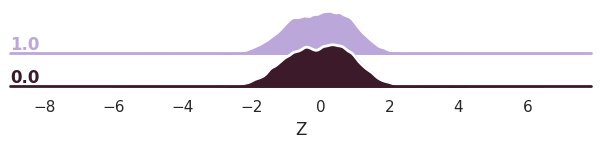

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

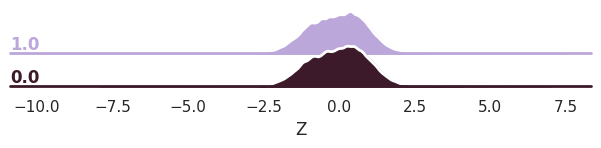

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

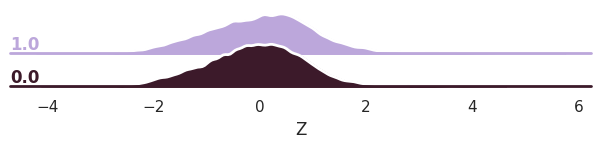

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

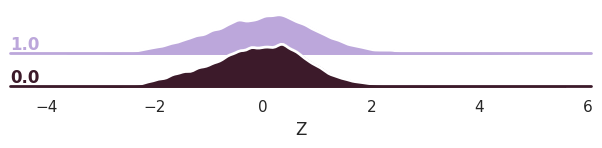

/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/preclineu/johbay/.conda/envs/py312/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to 

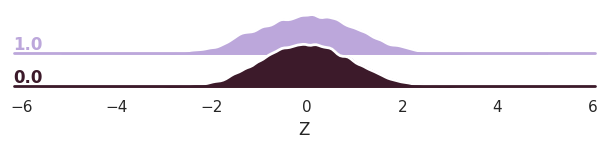

In [53]:
plot_ridge(
    norm_train, "Z", split_by="sex"
)  # We can also show the 'Y' variable, and that will show the marginal distribution of the response variable, per batch effect.

Evaluation statistcs are stored in the NormData object:

In [ ]:
display(train.get_statistics_df())
display(test.get_statistics_df())

## What's next?

Now we have a normative hierarchical Bayesian regression model, we can use it to:

- Make predictions on new data
- Harmonize data, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
- Synthesize new data
- Extend the model using data from new batches

### Predicting

In [ ]:
model.predict(test)

### Harmonize

In [ ]:
# Harmonizing is also easy:
reference_batch_effect = {
    "site": "Beijing_Zang",
    "sex": "M",
}  # Set a pseudo-batch effect. I.e., this means 'pretend that all data was from this site and sex'

model.harmonize(test, reference_batch_effect=reference_batch_effect)  # <- easy

plt.style.use("seaborn-v0_8")
df = test.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
sns.scatterplot(data=df, x=("X", "age"), y=("Y", feature_to_plot), hue=("batch_effects", "site"), ax=ax[0])
sns.scatterplot(data=df, x=("X", "age"), y=("Y_harmonized", feature_to_plot), hue=("batch_effects", "site"), ax=ax[1])
ax[0].title.set_text("Unharmonized")
ax[1].title.set_text("Harmonized")
ax[0].legend([], [])
ax[1].legend([], [])
ax[0].set_xlabel("Age")
ax[0].set_ylabel(feature_to_plot)
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)
plt.tight_layout()
plt.show()

### Synthesize

Our models can synthesize new data that follows the learned distribution. 

Not only the distribution of the response variables given a covariate is learned, but also the ranges of the covariates _within_ each batch effect. So if we have fitted a model on a number of sites, and subjects from A have an age between 10 and 20, then the synthesized pseudo-subjects from site A will also have an age between 10 and 20.

Not only that, but we also sample the batch effects in the frequency of the batch effects in the original data. So if the train data contained twice as many subjects from site A as site B, then the synthesized pseudo-subjects will also have twice as many subjects from site A as site B.

In [ ]:
# Generate 10000 synthetic datapoints from scratch
synthetic_data = model.synthesize(covariate_range_per_batch_effect=True, n_samples=1000)  # <- also easy
# Show the synthetic data along with the centiles
plot_centiles(
    model,
    covariate="age",  # Which covariate to plot on the x-axis
    scatter_data=synthetic_data,
    show_other_data=True,
    harmonize_data=True,
    show_legend=True,
)


In [ ]:
# Synthesize new Y data for existing X data
new_test_data = test.copy()

# Remove the Y data, this way we will synthesize new Y data for the existing X data
if hasattr(new_test_data, "Y"):
    del new_test_data["Y"]

synthetic = model.synthesize(new_test_data)  # <- will fill in the missing Y data

In [ ]:
plot_centiles(
    model,
    centiles=[0.05, 0.5, 0.95],  # Plot arbitrary centiles
    covariate="age",  # Which covariate to plot on the x-axis
    scatter_data=synthetic,  # Scatter the train data points
    batch_effects="all",  # You can set this to "all" to show all batch effects
    show_other_data=False,  # Show data points that do not match any batch effects
    show_centile_labels=True,
    harmonize_data=True,  # Set this to False to see the difference
    show_legend=False,  # Don't show the legend because it crowds the plot
)

## Next steps

Please see the other tutorials for more examples, and we also recommend you to read the documentation! As this toolkit is still in development, the documentation may not be up to date. If you find any issues, please let us know! 

Also, feel free to contact us on Github if you have any questions or suggestions.

Have fun modeling!

### Bonus content

Here is another model configuration using a SHASH likelihood, but this one also has a linear regression in epsilon and delta. If you have a feature that is heavily skewed and for which the skewness also changes with the covariates, this is the model for you:

In [ ]:
# Here's a model with a SHASHb likelihood, with a linear regression in all four parameters, so including epsilon and delta.
# This is a very flexible model, but it will also take a lot longer to run.
mu = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
        sigma=make_prior(dist_name="Gamma", dist_params=(3.0, 1.0)),
    ),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 2.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

epsilon = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)

delta = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    mapping="softplus",
    mapping_params=(
        0.0,
        3.0,  # Scale for smoothness
        0.6,  # We need to provide a vertical shift as well, because the SHASH mapping goes a bit wild with low values for delta
    ),
)

shashb2_regression_model = HBR(
    name="template",
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
    nuts_sampler="nutpie",
    likelihood=SHASHbLikelihood(mu, sigma, epsilon, delta),
)